In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, r2_score



#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("C:\\Users\\User\\Downloads\\Luminai-internship\\ay_df_all.csv", index_col='Time id',parse_dates=True)

In [3]:
df

,Material,Material_Id,Quantity,Total_Value
Time id,,,,
7,S21-010448-04,41504.0,9.0,3615772.83
8,S21-010448-04,41504.0,19.0,7418193.30
9,S21-010448-04,41504.0,17.0,6579470.22
10,S21-010448-04,41504.0,9.0,3425975.42
11,S21-010448-04,41504.0,7.0,2673483.99
...,...,...,...,...
35,AC37-000008,86.0,33.0,95237.05
36,AC37-000008,86.0,44.0,156749.66
37,AC37-000008,86.0,44.0,150426.96


In [4]:
df.shape

(3163, 4)

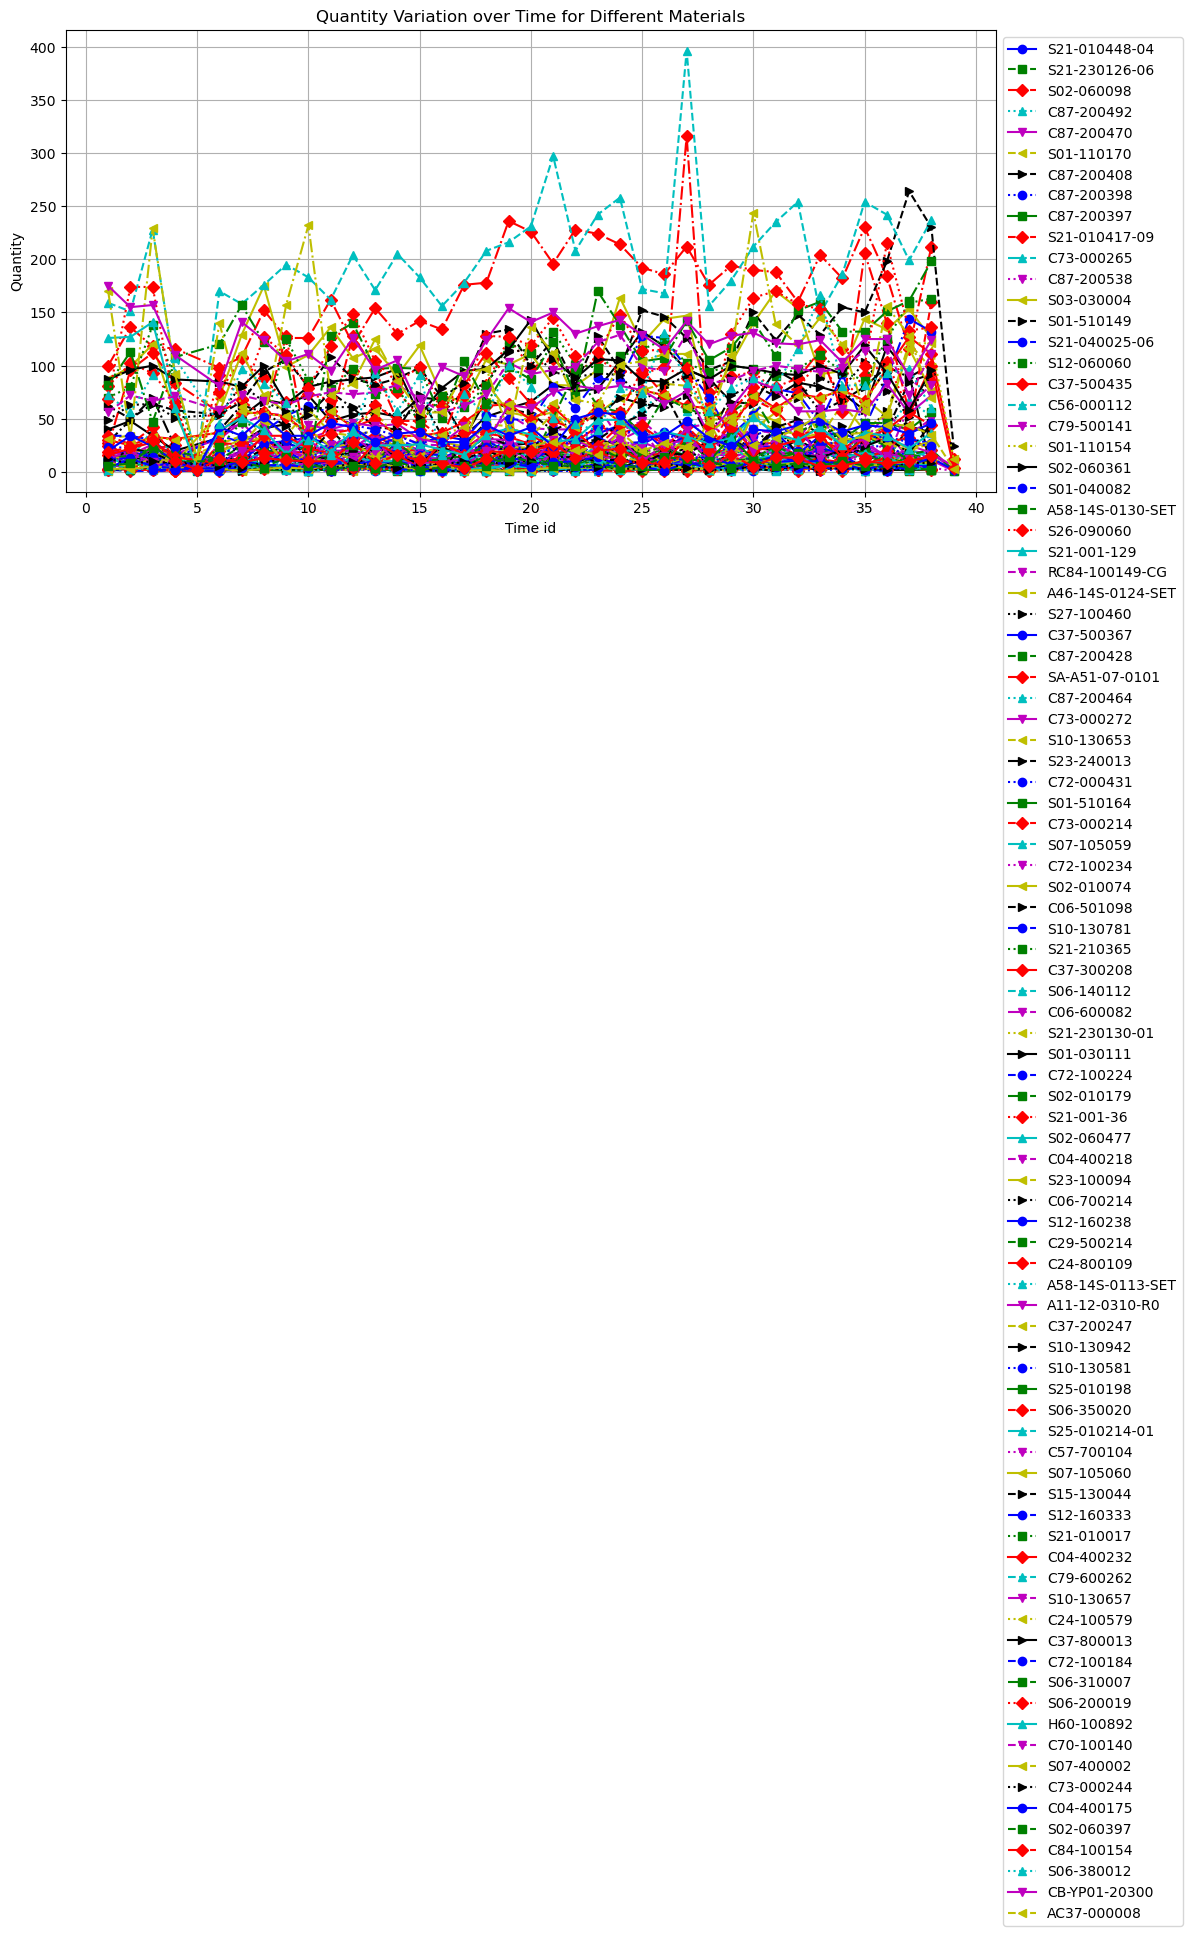

In [5]:
materials = df['Material'].unique()
plt.figure(figsize=(12, 6))

# Defining a list of colors, markers, and linestyles for better distinction
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['o', 's', 'D', '^', 'v', '<', '>']
linestyles = ['-', '--', '-.', ':']

# Plot each material with a different combination of color, marker, and linestyle
for i, material in enumerate(materials):
    material_data = df[df['Material'] == material]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    linestyle = linestyles[i % len(linestyles)]
    plt.plot(material_data.index, material_data['Quantity'], color=color, marker=marker, linestyle=linestyle, label=material)

plt.title('Quantity Variation over Time for Different Materials')
plt.xlabel('Time id')
plt.ylabel('Quantity')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.grid(True)
plt.show()

From the above trend plot of quantity over the time period, we can see that majority of the materials have the quantity range between 0-150 but certain materials also have a trend comparitively higher i.e., from 150 - 400

In [6]:
# Define a function to perform ADF test and return the p-value
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return the p-value

# Group the DataFrame by Material and iterate over each group
for material, group_df in df.groupby('Material'):
    p_value = adf_test(group_df['Quantity'])
    print(f"Material: {material}, ADF p-value: {p_value}")


Material: A11-12-0310-R0, ADF p-value: 0.0064305077189428265
Material: A46-14S-0124-SET, ADF p-value: 0.7246879814608874
Material: A58-14S-0113-SET, ADF p-value: 0.01842196050129096
Material: A58-14S-0130-SET, ADF p-value: 0.00037168375516668763
Material: AC37-000008, ADF p-value: 0.4352468724124643
Material: C04-400175, ADF p-value: 0.00023996686761226847
Material: C04-400218, ADF p-value: 0.0016253928136624777
Material: C04-400232, ADF p-value: 0.9987243747598297
Material: C06-501098, ADF p-value: 0.4537645517467133
Material: C06-600082, ADF p-value: 0.02115478206338298
Material: C06-700214, ADF p-value: 0.02863618693947658
Material: C24-100579, ADF p-value: 0.01013753475399767
Material: C24-800109, ADF p-value: 2.3099699725273402e-08
Material: C29-500214, ADF p-value: 0.002812217825444493
Material: C37-200247, ADF p-value: 0.023168392855818207
Material: C37-300208, ADF p-value: 0.9856450101653272
Material: C37-500367, ADF p-value: 0.0141029385232402
Material: C37-500435, ADF p-value

Above ADF test is performed to check whether the data is stationary. We can see the although the data is stationary for many of the Materials but certain Materials have a very bad p-value ex: Material: S23-240013, ADF p-value: 0.9979589076013591. Hence while choosing the order in ARIMA modelling, auto_arima is used. This automatically selects the best order for each Material.

In [7]:
grouped = df.groupby('Material')

# Initialize a dataframe to store forecasted values and evaluation metrics
results = pd.DataFrame(columns=['Material', 'Time id', 'Actual Quantity', 'Forecasted Quantity', 'MAE', 'R2 Score'])

# Loop through each material group
for name, group in grouped:
    # Train ARIMA model if there is sufficient data
    if len(group) >= 5:  # Ensure at least 5 data points for modeling (4 for training, 1 for forecasting)
        # Determine the ARIMA order using auto_arima
        model_auto = pm.auto_arima(group['Quantity'][:-4], seasonal=False, stepwise=True, trace=False)
        p, d, q = model_auto.order
        
        # Train ARIMA model
        model = ARIMA(group['Quantity'][:-4], order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast for the last 4 months
        forecast = model_fit.forecast(steps=4)
        
        # Store forecasted values and calculate evaluation metrics
        actual = group['Quantity'][-4:].values  # Actual values for the last 4 months
        mae = mean_absolute_error(actual, forecast)
        r2 = r2_score(actual, forecast)
        
        forecasted_df = pd.DataFrame({
            'Material': [name] * 4,
            'Time id': group.index[-4:],  # Last 4 months
            'Actual Quantity': actual,
            'Forecasted Quantity': forecast,
            'MAE': [mae] * 4,  # Same MAE for each of the last 4 months
            'R2 Score': [r2] * 4  # Same R2 Score for each of the last 4 months
        })
        
        results = pd.concat([results, forecasted_df], ignore_index=True)
    else:
        print(f"Data for Material {name} is insufficient for forecasting.")

# Display results
display(results)

,Material,Time id,Actual Quantity,Forecasted Quantity,MAE,R2 Score
0,A11-12-0310-R0,35,56.0,59.000000,11.000000,-0.412844
1,A11-12-0310-R0,36,83.0,59.000000,11.000000,-0.412844
2,A11-12-0310-R0,37,55.0,59.000000,11.000000,-0.412844
3,A11-12-0310-R0,38,72.0,59.000000,11.000000,-0.412844
4,A46-14S-0124-SET,35,7.0,7.846149,3.000000,-0.488324
...,...,...,...,...,...,...
355,S27-100460,38,37.0,30.809632,12.078207,-2.733663
356,SA-A51-07-0101,35,8.0,9.141390,3.687894,-0.070631
357,SA-A51-07-0101,36,13.0,9.506256,3.687894,-0.070631
358,SA-A51-07-0101,37,5.0,11.176677,3.687894,-0.070631


'results' dataframe forecasts for 35-38 months based upon the historical data available for each of the unique Materials. Even though we have the data for 35-38 months, we are forecasting it here so that we can evaluate the model first. The r2 score for maximum materials is negative and this model is not performing that good. For a clarity, the materials having a positive r2 score are displayed in the below dataframe.

In [8]:
# Filter the results dataframe to include only rows with a positive R2 Score
positive_r2_results = results[results['R2 Score'] > 0]

# Display the filtered dataframe
display(positive_r2_results)


,Material,Time id,Actual Quantity,Forecasted Quantity,MAE,R2 Score
192,S01-510149,35,9.0,12.575325,3.988657,0.065449
193,S01-510149,36,21.0,13.501074,3.988657,0.065449
194,S01-510149,37,10.0,13.833852,3.988657,0.065449
195,S01-510149,38,15.0,13.953476,3.988657,0.065449
208,S02-060098,35,230.0,192.700199,34.506708,0.012383
209,S02-060098,36,184.0,187.495915,34.506708,0.012383
210,S02-060098,37,116.0,190.027136,34.506708,0.012383
211,S02-060098,38,212.0,188.796019,34.506708,0.012383
220,S02-060477,35,18.0,9.935225,5.586423,0.239420
221,S02-060477,36,14.0,8.163051,5.586423,0.239420


# Forecasting for the months where Time id is not in current dataset

In [9]:
def forecast_material_quantity(df, forecast_steps=6):

    # Group data by Material
    grouped = df.groupby('Material')

    # Initialize a dataframe to store forecasted values
    forecast_df = pd.DataFrame(columns=['Material', 'Time id', 'Forecasted Quantity'])

    # Loop through each material group
    for name, group in grouped:
        # Train ARIMA model if there is sufficient data
        if len(group) >= 5:  # Ensure at least 5 data points for modeling
            # Select best ARIMA order using auto_arima
            model = auto_arima(group['Quantity'], seasonal=False, trace=False)
            
            # Forecast for the next `forecast_steps` months
            start_time_id = group.index.max() + 1
            end_time_id = start_time_id + forecast_steps - 1
            forecast = model.predict(n_periods=forecast_steps)
            
            # Store forecasted values
            forecasted_df = pd.DataFrame({
                'Material': [name] * forecast_steps,
                'Time id': list(range(start_time_id, end_time_id + 1)),
                'Forecasted Quantity': forecast
            })
            forecast_df = pd.concat([forecast_df, forecasted_df], ignore_index=True)
        else:
            print(f"Data for Material {name} is insufficient for forecasting.")
    
    return forecast_df

In [10]:
forecast_result = forecast_material_quantity(df)
display(forecast_result)

,Material,Time id,Forecasted Quantity
0,A11-12-0310-R0,39,67.406832
1,A11-12-0310-R0,40,67.406832
2,A11-12-0310-R0,41,67.406832
3,A11-12-0310-R0,42,67.406832
4,A11-12-0310-R0,43,67.406832
...,...,...,...
535,SA-A51-07-0101,40,12.783892
536,SA-A51-07-0101,41,8.751026
537,SA-A51-07-0101,42,11.626358
538,SA-A51-07-0101,43,9.479131


The above function forecast_material_quantity forecasts the Quantity for the months starting from 39th month. It takes two parameters. One is the dataframe and the second parameter 'forecast_steps' indicates for how many number of months the forecasting must be done.